In [1]:
!pip install torch==1.11 snntorch tqdm librosa numpy seaborn --extra-index-url https://download.pytorch.org/whl/cu113

import math

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import snntorch as snn
import snntorch.utils as utils
import librosa as lr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import snntorch as snn
from snntorch import surrogate

from IPython.display import Audio, HTML

from tqdm.notebook import tqdm, trange

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python3 -m pip install --upgrade pip


# Create a fake periodic signal

We start by creating a fake periodic spike signal. We do this by generating a sine wave and feeding that into
LIF neuron and generating a spike train.

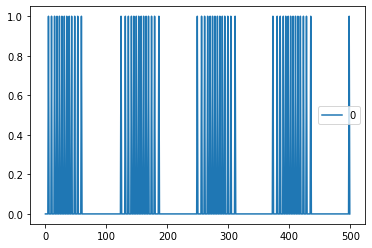

In [2]:

spike_conversion = snn.Leaky(
     beta=0.850854,
            learn_beta=False,
            learn_threshold=False,
            threshold=1,
            reset_mechanism='zero',
            init_hidden=True)


def generate_periodic_spike(frequency, phase=0):
    signal = (torch.sin(torch.linspace(phase, phase + 1, 500) * math.pi * frequency * 2) + 1) / 2

    spiketrain = torch.zeros((0, 1))
    amplitude = torch.rand(1) * 0.8
    for sig in (signal * (0.2 + amplitude)):
        spike = spike_conversion(torch.unsqueeze(sig, 0)).unsqueeze(0)
        spiketrain = torch.concat((spiketrain, spike), dim=0)
    
    return torch.unsqueeze(spiketrain, 0)
    
spiketrain = generate_periodic_spike(4)
sns.lineplot(data=spiketrain[0].detach().numpy())
plt.show()


# Modeling spike patterns over time

One of the important intutions for implementing temporal pattern recognition is that we can't expect a particular neuron to be spiking on every time step. The inputs will ostensibly be either 0 or 1. A spike will be predicated on an input having some value. And after a fire, the potential has some type of reset. So the key isn't going to be whether we can model some type of spike train on the input of some frequency. That's relatively easy to accomplish. The question is to not emit a spike if the input is not of the appropriate frequency. Even SNNs don't comprehensively model biological neurons. In this case, we're interested in inhibitory mechanics.

## Inhibitory Mechanics

To model this process manually, we imagine a case where we want to fire when we have a spike every 16 time steps, or every 18 time steps. But we don't want to fire if the spikes come every 2 time steps or 32 time steps.

Ensuring that we get a spike every 16 time steps is similar to the exercise done previously to model some minimum threshold volume to start a spike. However, that same neuron will be constantly firing if the input signal is firing every 2 time steps. And this is what we want to inhibit.

If we model the membrane potential a spike firing every 2 time steps, we say the input $I$ is alternating between 0 and 1.

$s_0 = 0$

$s_1 = \beta{s_0} + w{I_1} = w$

$s_2 = \beta{s_1} + w{0} = \beta{w}$

$s_3 = \beta{s_2} + w{I_3} = \beta^2{w} + w$

$s_4 = \beta{s_3} + w{0} = \beta^3{w} + \beta{w}$

$s_5 = \beta{s_4} + w{I_5} = \beta^4{w} + \beta^2{w} + w$

So we can simplify and say that given an odd time step which is where the potential is the strongest as we model it such that the input is firing on odd timesteps, that the membrane potential is equivalent to:

$\sum_{j=0}^{\lfloor\frac{n}{2}\rfloor}\beta^{2j}w$

More generally, if we say that an input spikes with a value of 1 weighted by an input weight $w$ every $\lambda$ time steps, that the maximum potential happens every $\lambda$ timesteps and can be calculated by:


$\sum_{j=0}^{\lfloor\frac{n}{\lambda}\rfloor}\beta^{\lambda{j}}w$

Armed with this, I propose an architecture using a combination of two neurons where one emits an inhibitory signal:

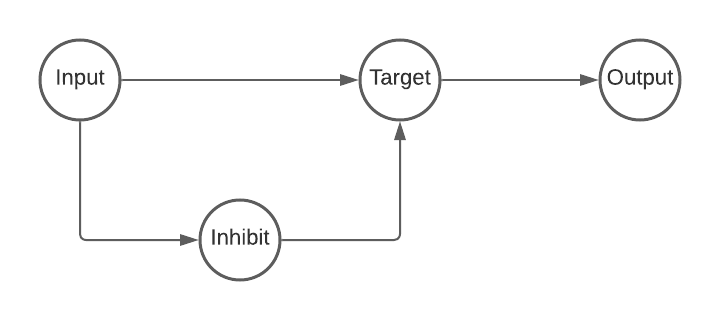

Where the input represents the input spike train. The inhibitory neuron is a standard Leaky and fire neuron but produces an inhibitory effect when recombined with the input in the form:

$-w_\tau\sum_{j=0}^{n}\beta_{\tau}^{j}w_\theta{I_{j}}$

So now the inhibition is recombined with the excitation spike and fed to an output Leaky and Fire neuron:

$\sum_{j=0}^{n}\beta_{\theta}^{j}w_\theta{I_{j}}$

And thus the membrane potential for firing at timestep n becomes:

$\sum_{j=0}^{n}\beta_{\theta}^{j}w_\theta I_{j} - w_\tau\sum_{j=0}^{n}\beta_{\tau}^{j}w_\theta{I_{j}}$

## Modelling example

Next, consider the example above. We want our spike train to fire if there is a periodic pulse every 16 or 18 milliseconds. But we inhibit if the pulse frequency is too high. 

### Signaling neuron

For the sake of experimentation, we'll model a pulse every 18 time steps as being the target. So we model the spike for every 18 time steps, modelling for having a spike occur at 19 time steps (enough for 2 of the 18 steps).

$\sum_{j=0}^1\beta^{18j}w \geq 1$

$\beta^{18}w + w \geq 1$

$\beta^{18} + 1 \geq \frac{1}{w}$

We'll arbitrarily say that w will be 0.9 in this example. This may be a learned parameter in a general SNN use case, along with beta, where a minima of beta exists for any 0 < w < 1.

$\beta^{18} + 1 \geq \frac{10}{9}$

$\beta^{18} \geq \frac{1}{9}$

Using wolfram alpha to get an approximation:

$\beta_\theta \geq 0.88509$

### Inhibitory neuron

Now we say that an impulse every 15 timesteps will be too frequent. So we perform the same exercise here:

$\sum_{j=0}^1\beta^{15j}w \geq 1$

$\beta^{15} \geq \frac{1}{9}$

$\beta_\tau = 0.86375$

We use ceil to the decimal place so we constrain a tiny bit above 15 instead of below, mostly for the graphs to demonstrate the effect


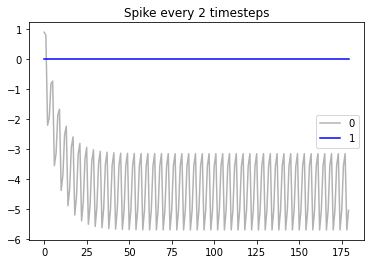

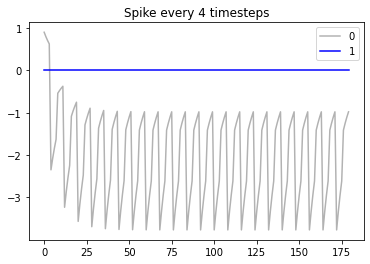

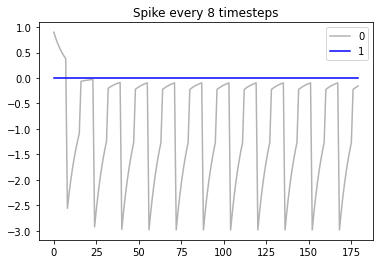

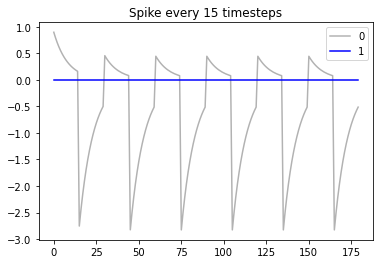

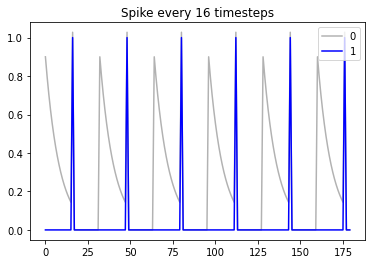

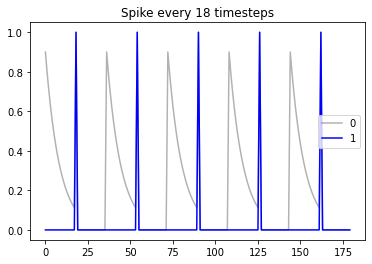

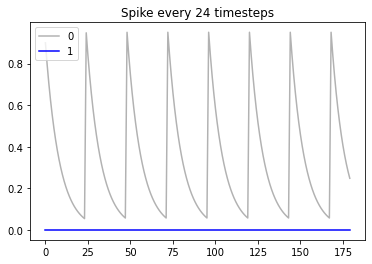

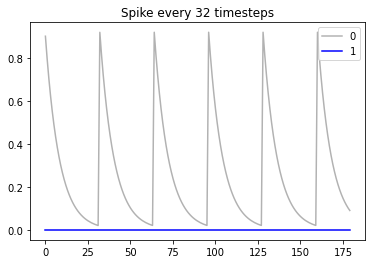

In [230]:
from snntorch import surrogate

surrogate_function=surrogate.fast_sigmoid(slope=8)

class LeakyTemporal(nn.Module):
    
    class InhibitGradient(torch.autograd.Function):
        @staticmethod
        def forward(ctx, input, inhibit, tau):
            ctx.save_for_backward(input, inhibit)
            return input, ((inhibit * -2) + 1), tau
        
        @staticmethod
        def backward(ctx, input_gradient, inhibit_gradient, tau_gradient):
            input, inhibit = ctx.saved_tensors
            
            # if there is a drive to push the inhibition value down via a positive gradient, 
            # but there was no inhibition, ignore it
            inhibit_gradient[(inhibit_gradient > 0.) * (inhibit == 0.)] = 0.
            
            # otherwise, if there was no spike to suppress, don't push the inhibition value down
            inhibit_gradient[(inhibit_gradient > 0.) * (input == 0.)] = 0.
            
            tau_gradient *= torch.sum(((inhibit_gradient <= 0.) + (inhibit != 0.)) > 0) / inhibit_gradient.nelement()
            
            # otherwise, if the gradient pushing up, it should not increase if
            # there was either no input present or if the input was inhibited
            #inhibit_gradient[((inhibit_gradient < 0.) * ((input == 0) + inhibit)) > 0.] = 0
            inhibit_gradient[(inhibit_gradient < 0.) > 0.] = 0
            return None, inhibit_gradient, tau_gradient
    
    def __init__(self, beta_theta, w_theta, beta_tau, w_tau = None, learn_w_tau = False):
        super().__init__()
        
        if w_tau is None:
            w_tau = 2.
        
        self.w_theta = torch.nn.Parameter(torch.tensor(w_theta), requires_grad=False)
        self.w_tau = torch.nn.Parameter(torch.tensor(w_tau), requires_grad=learn_w_tau)
        
        self._inhibit = snn.Leaky(
            beta=beta_tau,
            learn_beta=True,
            learn_threshold=False,
            threshold=1.,
            spike_grad=surrogate_function,
            reset_mechanism='zero',            
            init_hidden=True)
        
        self.beta_tau = self._inhibit.beta
        
        self._fire = snn.Leaky(
            beta=beta_theta,
            learn_beta=True,
            learn_threshold=False,
            threshold=1.,
            spike_grad=surrogate_function,
            reset_mechanism='zero')

        self.beta_theta = self._fire.beta
        
        self._inhibit_grad = LeakyTemporal.InhibitGradient.apply
        
        self._mem = self._fire.init_leaky()
        
    def reset(self):
        utils.reset(self)
        self._mem = self._fire.init_leaky()

    def forward(self, x):

        #_, inhibition, tau = self._inhibit_grad(
        #    x,
        #    self._inhibit(x * self.w_theta), 
        #    self.w_tau)
        inhibition = ((self._inhibit(x * self.w_theta) * -2) + 1)
            
        out, mem = self._fire(x * inhibition * self.w_theta, self._mem)
        inhibit_tau = torch.relu(-inhibition).detach() * self.w_tau
        mem = mem - inhibit_tau
        
        self._mem = mem
        return out, self._mem * 1.


# model a fire every n time steps
emodel = LeakyTemporal(beta_theta=0.88509, w_theta=0.9, beta_tau=0.86375)
emodel.eval()

def model_every_n(n):
    out = []
    mem = []

    with torch.no_grad():
        emodel.reset()
        for i in range(180):
            in_tensor = torch.ones((1,)) if (i % n) == 0 else torch.zeros((1,))
            cout, cmem = emodel(in_tensor)
            out.append(cout.detach().numpy())
            mem.append(cmem.detach().numpy())

    sns.lineplot(data = np.array([mem,  out]).squeeze(-1).transpose(1, 0),
                 palette = [(0, 0, 0, 0.3), 'blue'],
                 dashes=False).set(title=f'Spike every {n} timesteps')
    plt.show()

model_every_n(2)
model_every_n(4)
model_every_n(8)
model_every_n(15)
model_every_n(16)
model_every_n(18)
model_every_n(24)
model_every_n(32)

The parameters that were manually calculated are among the parameters to be learned by the model:

* $\beta_\tau$
* $\beta_\theta$
* $w_\tau$

# Training

The question now is whether we can train a model to find these parameters. We want the model to recognize spikes that occur in 30 to 40 timesteps without having to do all of the manual math above


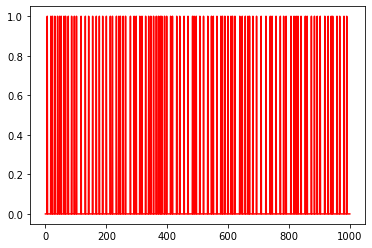

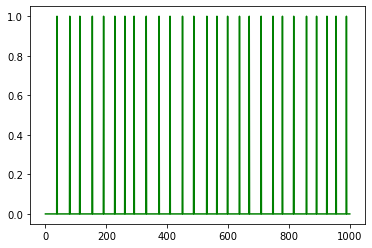

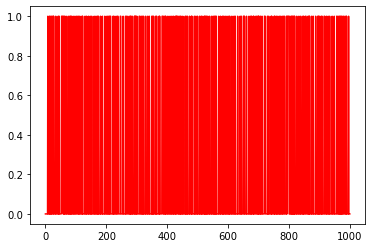

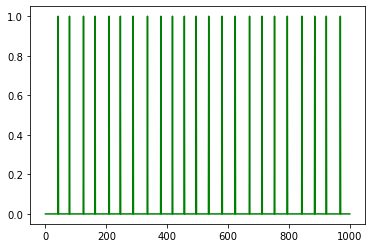

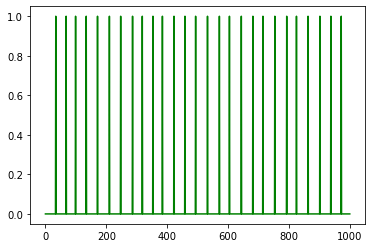

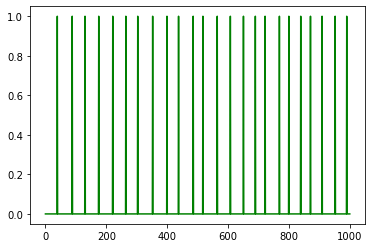

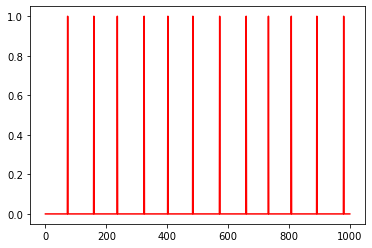

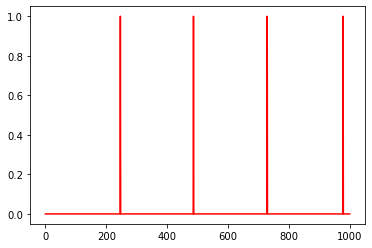

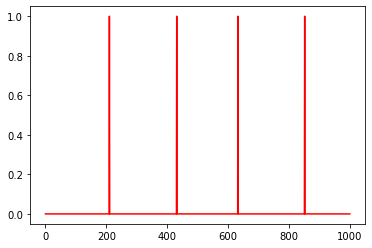

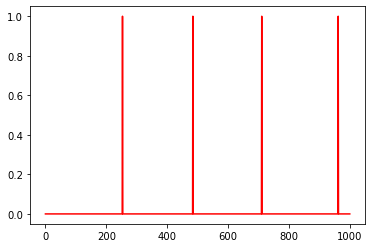

In [231]:
def generate_periodic_signal(min_freq, max_freq, length = 1000):
    
    result = torch.zeros(length)
    
    return result
    
def generate_batch(batch_size, elem_size, target_min, target_max):
    result_x = torch.zeros((batch_size, elem_size))
    result_y = torch.zeros(batch_size)
    
    range_starts = torch.randint(1, target_min, (batch_size,))
    one_third_batch = int(batch_size / 3)
    range_starts[one_third_batch:] = torch.randint(target_min, target_max, (batch_size - one_third_batch,))
    
    range_starts[one_third_batch * 2:] += torch.randint(target_max - target_min, 200, (batch_size - (one_third_batch * 2),))
    range_lengths = torch.randint(1, (target_max - target_min) * 2, (batch_size,))
    
    for batch_element in range(batch_size):
        range_min = range_starts[batch_element]
        range_max = range_min + range_lengths[batch_element]
        
        is_target_range = range_max >= target_min and range_min <= target_max
        if is_target_range:
            # the range overlaps - see if we should move it into
            # the target, or out
            left = False
            encompassed = False
            
            if range_min <= target_min:
                left = True
                overlap = (min(range_max, target_max) - target_min) / (target_max - target_min )
            elif range_max > target_max:
                overlap = (target_max - range_min) / (target_max - target_min )
            else:
                encompassed = True
                
            if not encompassed:
                # if the whole range isn't within the target:
                # if it's overlapping our target by at least 50%
                # move it into the target. Otherwise, move it out
                if overlap >= 0.5:
                    if left:
                        range_min = target_min
                    else:
                        range_max = target_max
                else:
                    if left:
                        range_max = target_min - 1
                        if range_min >= range_max:
                            range_min = range_max - 1
                    else:
                        range_min = target_max
                    is_target_range = False

        # we have our rage that we're going to generate - generate it
        offsets = torch.randint(range_min, range_max, (int(elem_size / range_min),))
        for i in range(1, offsets.shape[0]):
            offsets[i] = offsets[i - 1] + offsets[i]

        result_x[batch_element, offsets[offsets < elem_size]] = 1
        result_y[batch_element] = is_target_range
        
    return result_x, result_y
    
x, y = generate_batch(10, 1000, 30, 50)
for i in range(x.shape[0]):
    sns.lineplot(data=x[i].numpy(), color='green' if y[i] else 'red')
    plt.show()

## Sequential Model Wrapper

The nature of SNNs are such that they run recursively. As such, each timestep must be run independently. So we built a wrapper that can do that

In [232]:

class SequentialWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()

        self._model = model
        
    def reset(self):
        utils.reset(self)
        self._model.reset()
        
    def forward(self, x):   
        out_spk = None
        out_mem = None
        
        for i in range(x.shape[1]):
            xi = x[:, i, ...]
            cm, mm = self._model(xi)
            
            if i == 0:
                out_spk = cm.unsqueeze(1)
                out_mem = mm.unsqueeze(1)
            else:
                out_spk = torch.concat((out_spk, cm.unsqueeze(1)), dim=1)
                out_mem = torch.concat((out_mem, mm.unsqueeze(1)), dim=1)
                
        return out_spk, out_mem


Using this layer, we build a simple model that collapses that layer into a single output neuron telling us whether the singal is exactly the target frequency.

In [246]:
import snntorch.functional as SF

class SimplisticTargetFrequency(nn.Module):
    def __init__(self, max_range = 50):
        super().__init__()
        inner = LeakyTemporal(
            w_theta=0.9,
            beta_theta=0.9,
            beta_tau=0.9,
            #beta_theta=0.957007,
            #beta_tau=0.927033,
            w_tau=2.,
            learn_w_tau=True)
        self._conv = SequentialWrapper(inner)
        
        self._pool = nn.MaxPool1d(max_range, stride = math.ceil(max_range / 2))
        
    def reset(self):
        self._conv.reset()
        utils.reset(self)
        
    def forward(self, x):
        x, m = self._conv(x)
        x = self._pool(x.squeeze(-1))
        m = self._pool(m.squeeze(-1))
        return x, m

target_frequency_min = 30
target_frequency_max = 50
    
device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')
model = SimplisticTargetFrequency(101).to(device)

#model.load_state_dict(torch.load('temporal-patterns.pth'))
#best_loss = 6000
print(list(model.parameters()))


[Parameter containing:
tensor(0.9000, device='cuda:0'), Parameter containing:
tensor(2., device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9000, device='cuda:0', requires_grad=True), Parameter containing:
tensor(0.9000, device='cuda:0', requires_grad=True)]


## Training loop

Now I use the synthetic batch builder to train a model to target a particular frequency range. I won't tell it anything about the range to target. I will just tell it which examples are in the range.

In [247]:

optimizer = optim.NAdam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))
#optimizer = optim.RMSprop(model.parameters())
loss_fn = nn.L1Loss(reduction='mean')

number_of_batch_runs = 25
epochs_per_batch = 5
batch_size = 1000
samples_per_batch = 1000

validation_loss = math.inf
with tqdm(total = number_of_batch_runs * (epochs_per_batch + 2)) as pbar:
    for epoch in range(number_of_batch_runs):
        with torch.no_grad():
            x, y = generate_batch(batch_size, samples_per_batch, target_frequency_min, target_frequency_max)
            x = x.to(device)
            y = y.to(device)
        pbar.update()

        model.train()
        train_loss = []
        for i in range(epochs_per_batch):
            optimizer.zero_grad()
            model.reset()
            predicted, membrane = model(x)
            
            # use the membrane potential for positive examples, otherwise, use the prediction
            membrane = torch.clamp(membrane, 0, 1)
            #predicted[y == 1, :] = membrane[y == 1, :]
            
            loss_val = loss_fn(predicted, y.unsqueeze(-1).expand(list(y.shape) + [predicted.shape[-1]]))
            loss_val.backward()
            optimizer.step()
            train_loss.append(loss_val.detach().cpu().numpy())
            pbar.update()


        # validation run
        with torch.no_grad():
            model.eval()
            model.reset()

            for name, param in model.named_parameters():
                if param.requires_grad:
                    print(name, param.data)

            x, y = generate_batch(int(batch_size / 5), samples_per_batch, target_frequency_min, target_frequency_max)
            x = x.to(device)
            y = y.to(device)
            predicted, _ = model(x)

            accuracy = torch.mean(1 - torch.abs(predicted.mode(dim=1)[0] - y))
            validation_loss = loss_fn(predicted, y.unsqueeze(-1).expand(list(y.shape) + [predicted.shape[-1]])).item()
            print(f"Accuracy: {round(accuracy.item() * 100, 3)}%, Train Loss: {np.mean(train_loss)}, Validation Loss: {validation_loss}\n")
            #if loss_val < best_loss:
            #    torch.save(model.state_dict(), 'temporal-patterns.pth')
            #    print('Saved model state')
            #    best_loss = loss_val
                
            pbar.set_description(f'Valid Loss: {validation_loss}')
            pbar.update()


  0%|          | 0/175 [00:00<?, ?it/s]

_conv._model.w_tau tensor(2.0033, device='cuda:0')
_conv._model.beta_tau tensor(0.9023, device='cuda:0')
_conv._model.beta_theta tensor(0.9034, device='cuda:0')
Accuracy: 69.5%, Train Loss: 0.3099111020565033, Validation Loss: 0.3058333396911621

_conv._model.w_tau tensor(2.0077, device='cuda:0')
_conv._model.beta_tau tensor(0.9058, device='cuda:0')
_conv._model.beta_theta tensor(0.9069, device='cuda:0')
Accuracy: 70.0%, Train Loss: 0.33008891344070435, Validation Loss: 0.3016666769981384

_conv._model.w_tau tensor(2.0122, device='cuda:0')
_conv._model.beta_tau tensor(0.9100, device='cuda:0')
_conv._model.beta_theta tensor(0.9109, device='cuda:0')
Accuracy: 72.5%, Train Loss: 0.344011127948761, Validation Loss: 0.2750000059604645

_conv._model.w_tau tensor(2.0156, device='cuda:0')
_conv._model.beta_tau tensor(0.9136, device='cuda:0')
_conv._model.beta_theta tensor(0.9156, device='cuda:0')
Accuracy: 66.5%, Train Loss: 0.34065553545951843, Validation Loss: 0.3361111283302307

_conv._mode

Even with the custom backpropagation gradients, we still had lackluster results. Our best parameters maybe achieved an accuracy of 65%. That's only slightly better than chance. We'll look at some examples

beta tensor(0.9247, device='cuda:0')


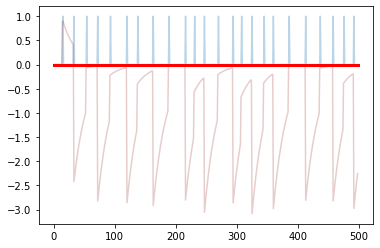

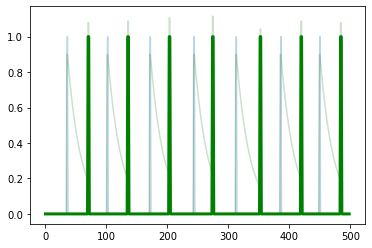

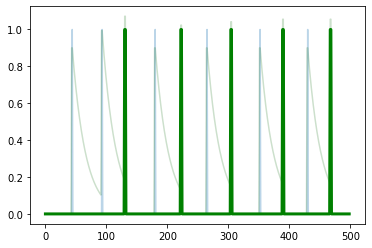

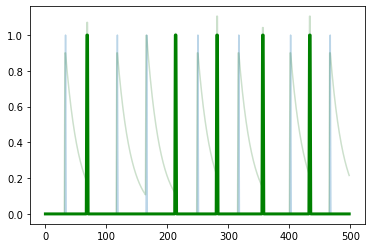

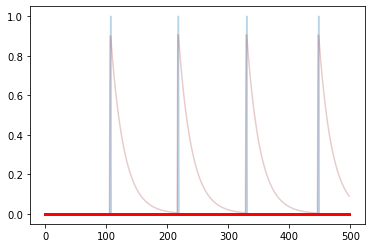

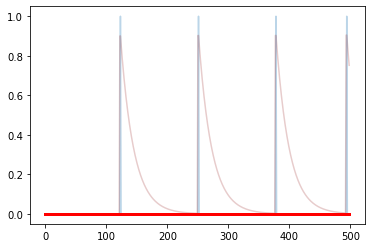

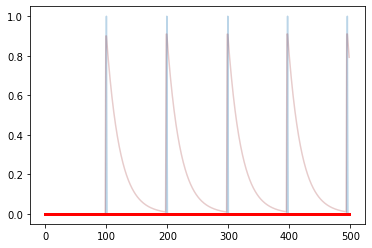

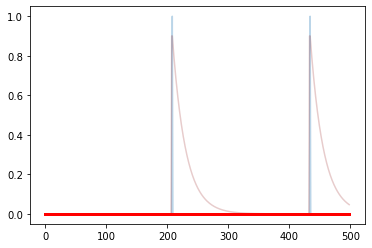

In [255]:
spiketrain = spiketrain.to(device)

emodel = SimplisticTargetFrequency(2).to(device)
emodel.load_state_dict(torch.load('temporal-patterns.pth'))

for name, param in emodel._conv._model._inhibit.named_parameters():
    if param.requires_grad:
        print(name, param.data)


emodel.eval()
with torch.no_grad():
    x, y = generate_batch(8, 500, 30, 50)
    x = x.to(device)
        
    emodel.reset()
    data, membrane = emodel(x)
    
    for i in range(x.shape[0]):
        sns.lineplot(data=x[i].cpu().detach().numpy(), alpha=0.3)
        sns.lineplot(data=membrane[i].cpu().detach().numpy(), color='darkgreen' if y[i] else 'darkred', alpha=0.2)
        sns.lineplot(data=data[i].cpu().detach().numpy(), color='green' if y[i] else 'red', linewidth=3)
        plt.show()
